In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from analyzer.model.regression_model import RegressionModel
from data.io import Reader, Saver
from data.plot import Drawer
from analyzer.stat_criterion.stat_criteria import StatCriteria
from data.encoder import Encoder
from data.normalizer import Normalizer
from data import DataPreparation

from statsmodels.stats.outliers_influence import variance_inflation_factor


In [40]:
# читаем датасет в память из внешнего источника
df_original = Reader.read_csv('https://raw.githubusercontent.com/Semendyeav/datasets/main/PDA120_Moscow_Price.csv')
mask = df_original['region']=='Moscow'
df = df_original[mask].copy().reset_index(drop=True)
df = df.drop('region', axis = 1)
df.head(10)

,price,apartment_type,metro_station,minutes_to_metro,number_of_rooms,area,living_area,kitchen_area,floor,number_of_floors,renovation
0,118575675.0,Secondary,Выставочная,7.0,3.0,105.70,84.8,15.9,25.0,67,Designer
1,145000000.0,Secondary,Парк культуры,5.0,4.0,170.00,125.0,18.0,2.0,6,Designer
2,10607020.0,New building,Братиславская,13.0,2.0,59.59,27.1,16.7,11.0,16,Cosmetic
3,20500000.0,Secondary,Динамо,8.0,2.0,40.00,30.0,5.0,12.0,6,Designer
4,2900000.0,Secondary,Текстильщики,16.0,0.0,15.00,9.7,7.9,1.0,16,Cosmetic
5,9642880.0,New building,Кантемировская,20.0,1.0,41.60,15.4,18.0,19.0,14,Cosmetic
6,11853600.0,New building,Депо,19.0,2.0,67.35,34.1,14.2,7.0,11,Cosmetic
7,19990000.0,Secondary,Бульвар Рокоссовского,26.0,3.0,72.90,43.4,8.5,9.0,14,Cosmetic
8,27990000.0,Secondary,Шелепиха,13.0,3.0,79.10,48.0,11.8,10.0,53,Without renovation
9,12936000.0,New building,Кантемировская,20.0,2.0,58.80,25.6,19.4,19.0,14,Cosmetic


In [41]:
# посмотрим на пропуски в данных
df.isna().sum()

price               0
apartment_type      0
metro_station       0
minutes_to_metro    0
number_of_rooms     0
area                0
living_area         0
kitchen_area        0
floor               0
number_of_floors    0
renovation          0
dtype: int64

Выводы:
1. форматирование названий колонок произведено
2. пропуски в данных отсутствуют
3. датасет не оптимизирован по использованию памяти

In [42]:
# Посмотрим статистику о датасете
df.describe()

,price,minutes_to_metro,number_of_rooms,area,living_area,kitchen_area,floor,number_of_floors
count,1.611300e+04,16113.000000,16113.000000,16113.000000,16113.000000,16113.000000,16113.000000,16113.000000
mean,4.798348e+07,12.535344,2.222057,81.922181,43.884596,13.594830,9.119531,16.421833
std,9.573436e+07,6.790625,1.671017,78.197326,43.645793,8.625711,8.272039,11.254795
min,1.150000e+06,0.000000,0.000000,6.000000,2.000000,1.000000,1.000000,1.000000
25%,1.020000e+07,7.000000,1.000000,38.800000,18.000000,8.700000,3.000000,9.000000
50%,1.595000e+07,12.000000,2.000000,60.000000,31.900000,11.300000,7.000000,14.000000
75%,4.000000e+07,17.000000,3.000000,93.300000,51.000000,16.200000,13.000000,20.000000
max,2.455020e+09,60.000000,12.000000,1117.000000,566.800000,122.000000,92.000000,97.000000


Выводы:
1. среднее и медиана имеют близкие значения, что говорит о близком к нормальному распределению
2. среднее сравнимо со стандартным отклонением, что говорит о пологости распределения
3. максимальные значения сильно отличаются от третьего квантиля, что говорит о наличии выбросов вправо

In [43]:
# смотрим на типы данных и требования к памяти
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16113 entries, 0 to 16112
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price             16113 non-null  float64
 1   apartment_type    16113 non-null  object 
 2   metro_station     16113 non-null  object 
 3   minutes_to_metro  16113 non-null  float64
 4   number_of_rooms   16113 non-null  float64
 5   area              16113 non-null  float64
 6   living_area       16113 non-null  float64
 7   kitchen_area      16113 non-null  float64
 8   floor             16113 non-null  float64
 9   number_of_floors  16113 non-null  int64  
 10  renovation        16113 non-null  object 
dtypes: float64(7), int64(1), object(3)
memory usage: 1.4+ MB


In [44]:
# Оптимизируем память
df['floor'] = df['floor'].astype('uint8')
df['number_of_rooms'] = df['number_of_rooms'].astype('uint8')
df['minutes_to_metro'] = df['minutes_to_metro'].astype('uint8')
df['number_of_floors'] = df['number_of_floors'].astype('uint8')
df['area'] = df['area'].astype('float32')
df['kitchen_area'] = df['kitchen_area'].astype('float32')

# Переведем суммы в рублях в млн
df['price'] /= 1_000_000

# Убеждаемся в изменениях
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16113 entries, 0 to 16112
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price             16113 non-null  float64
 1   apartment_type    16113 non-null  object 
 2   metro_station     16113 non-null  object 
 3   minutes_to_metro  16113 non-null  uint8  
 4   number_of_rooms   16113 non-null  uint8  
 5   area              16113 non-null  float32
 6   living_area       16113 non-null  float64
 7   kitchen_area      16113 non-null  float32
 8   floor             16113 non-null  uint8  
 9   number_of_floors  16113 non-null  uint8  
 10  renovation        16113 non-null  object 
dtypes: float32(2), float64(2), object(3), uint8(4)
memory usage: 818.4+ KB


In [45]:
# Убеждаемся в том, что не произошла потеря данных
df.describe()

,price,minutes_to_metro,number_of_rooms,area,living_area,kitchen_area,floor,number_of_floors
count,16113.000000,16113.000000,16113.000000,16113.000000,16113.000000,16113.000000,16113.000000,16113.000000
mean,47.983478,12.535344,2.222057,81.922180,43.884596,13.594831,9.119531,16.421833
std,95.734362,6.790625,1.671017,78.197327,43.645793,8.625711,8.272039,11.254795
min,1.150000,0.000000,0.000000,6.000000,2.000000,1.000000,1.000000,1.000000
25%,10.200000,7.000000,1.000000,38.799999,18.000000,8.700000,3.000000,9.000000
50%,15.950000,12.000000,2.000000,60.000000,31.900000,11.300000,7.000000,14.000000
75%,40.000000,17.000000,3.000000,93.300003,51.000000,16.200001,13.000000,20.000000
max,2455.020000,60.000000,12.000000,1117.000000,566.800000,122.000000,92.000000,97.000000


Выводы:
1. уменьшили размер датасета с 1.5 до 1.0 МБ
2. убедились, что значения при изменении типа данных не потеряны
3. изменение цены слишком высокое от 1,15 до 2455,02 млн. рублей, поэтому надо убедиться как данные распределены в нашем датасете. Скорее всего придётся разделять датасет.

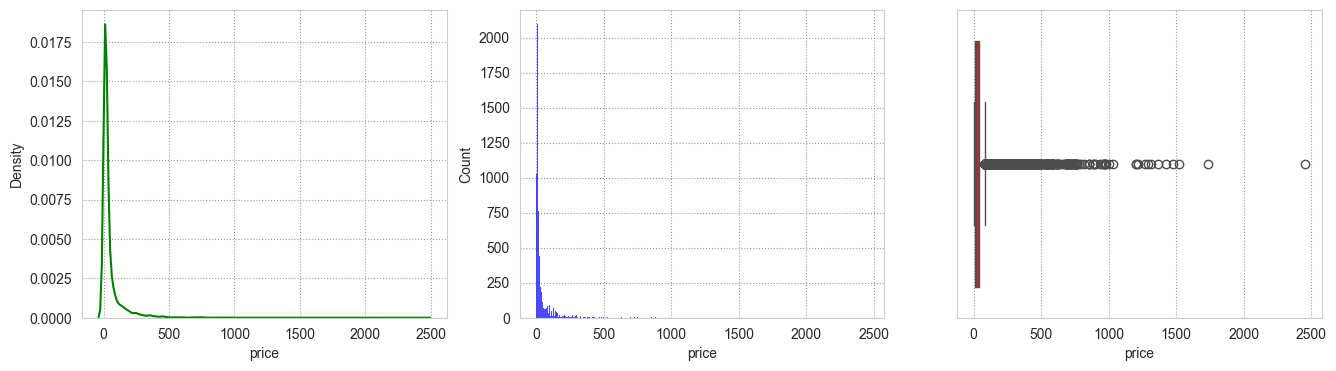

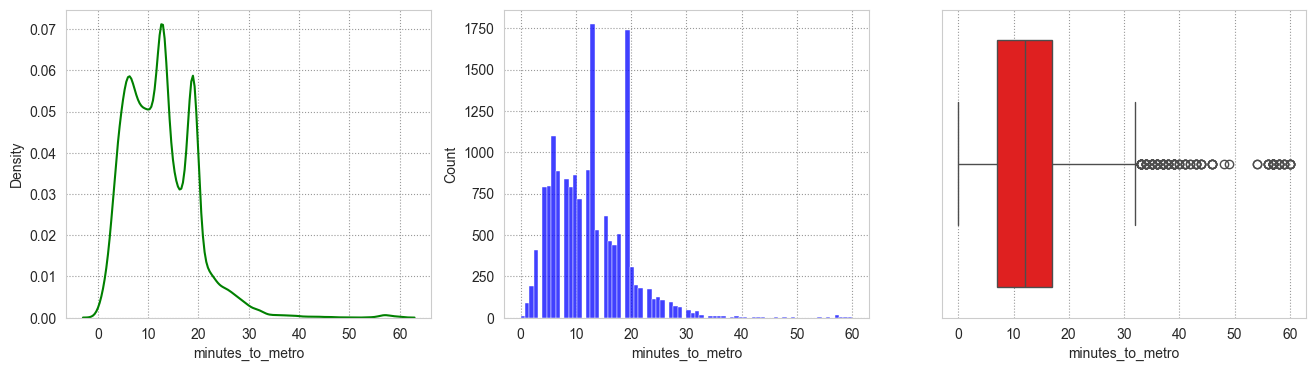

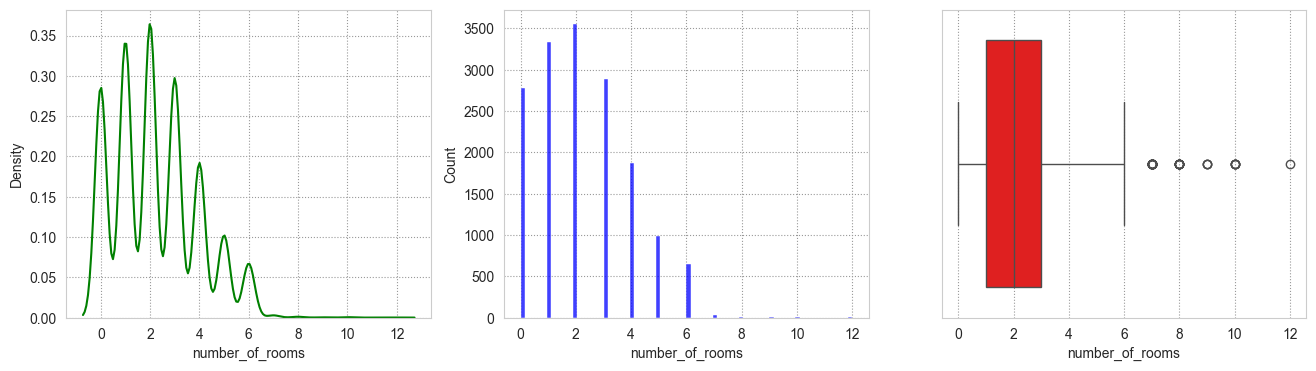

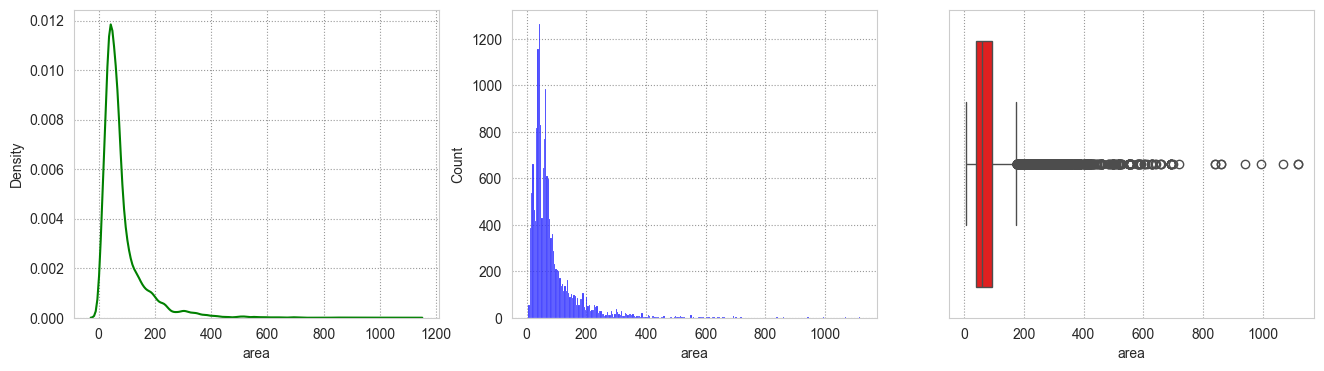

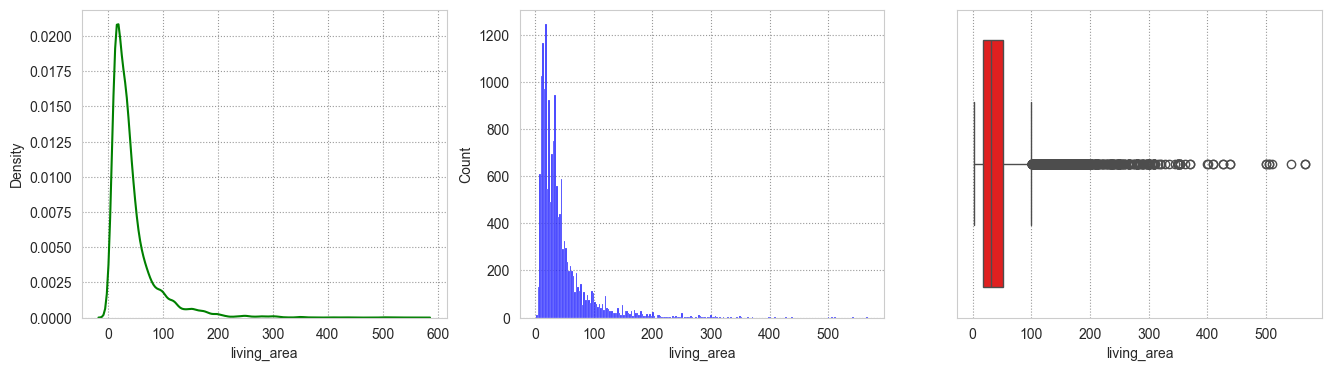

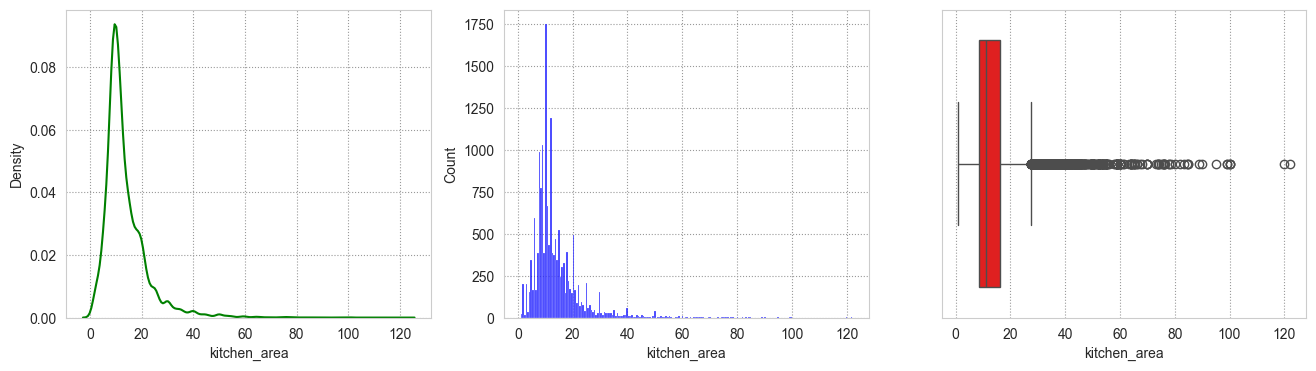

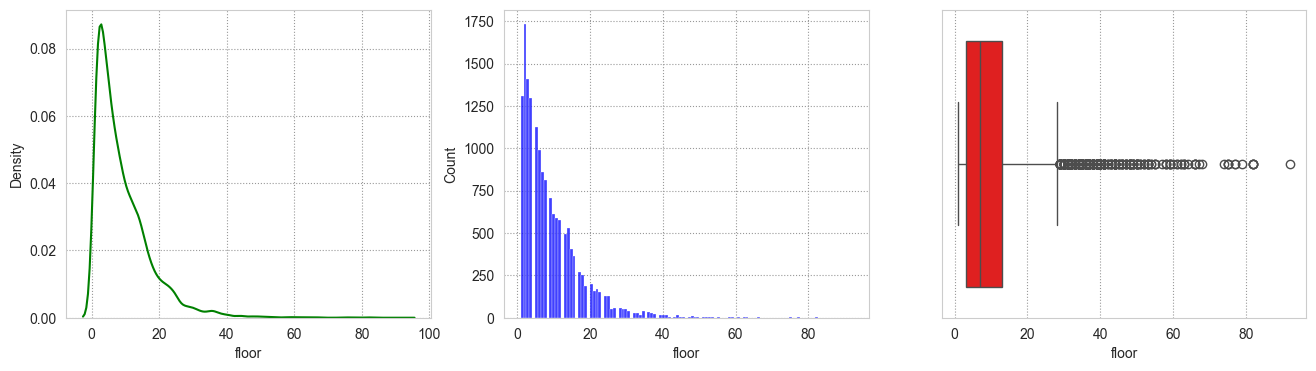

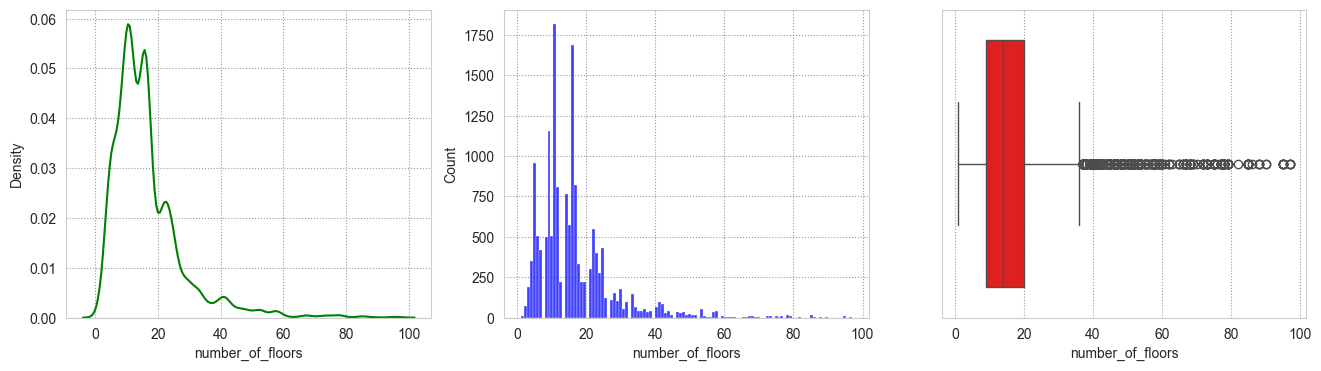

In [46]:
# Посмотрим на виды распределений "числовых" параметров и на ящики с усами
Drawer.plot_numeric_seaborn(df)

Выводы:

1. price - большое количество однократных выбросов свыше значения 100 млн рублей, о виде распределения сказать что-то трудно.

2. minutes_to_metro - распределение имеет небольшое количество выбросов при значениях свыше 28 минут, но в целом наблюдается близкое к нормальному распределение (медиана и среднее совпадают).

3. number_of_rooms - редко встречаются квартиры свыше 6 комнат, в целом распределение близкое к нормальному (медиана и среднее совпадают).

4. area, living_area, kitchen_area - очень схожие между собой данные, что говорит об их избыточности. В целом наблюдается большое количество выбросов аналогичных, как на графике сценой. Возможно стоит перейти к исследованию признака "цены за квадратный метр".

5. floor - этажность выше 30 редкая, большая часть предложений это квартиры на низких этажах до 10.

6. number_of_floors - этажность выше 30 редкая, распределение построек по этажности носит близкий к нормальному характер.

In [47]:
# Разбиваем датасет на два
Q1 = df['price'].quantile(.25)
Q3 = df['price'].quantile(.75)
IQR = Q3 - Q1
mask = df['price'] < Q3 + 1.5*IQR

df_lowcost = df[mask]
Saver().save_csv(df_lowcost, 'df_lowcost', False)

df_elite = df[~mask]
Saver().save_csv(df_elite, 'df_elite', False)

print(f'цена разделяющая элитную и обычную недвижимости: {Q3 + 1.5*IQR}')

Файл успешно сохранён: ./dataset/df_lowcost.csv
Файл успешно сохранён: ./dataset/df_elite.csv
цена разделяющая элитную и обычную недвижимости: 84.7


## Анализ обычной недвижимости
Подробный анализ данных обычной недвижимости находится здесь:
[lowcost.ipynb](./lowcost.ipynb).

## Анализ элитной недвижимости
Подробный анализ данных элитной недвижимости можно найти в этом файле:
[elite.ipynb](./elite.ipynb).


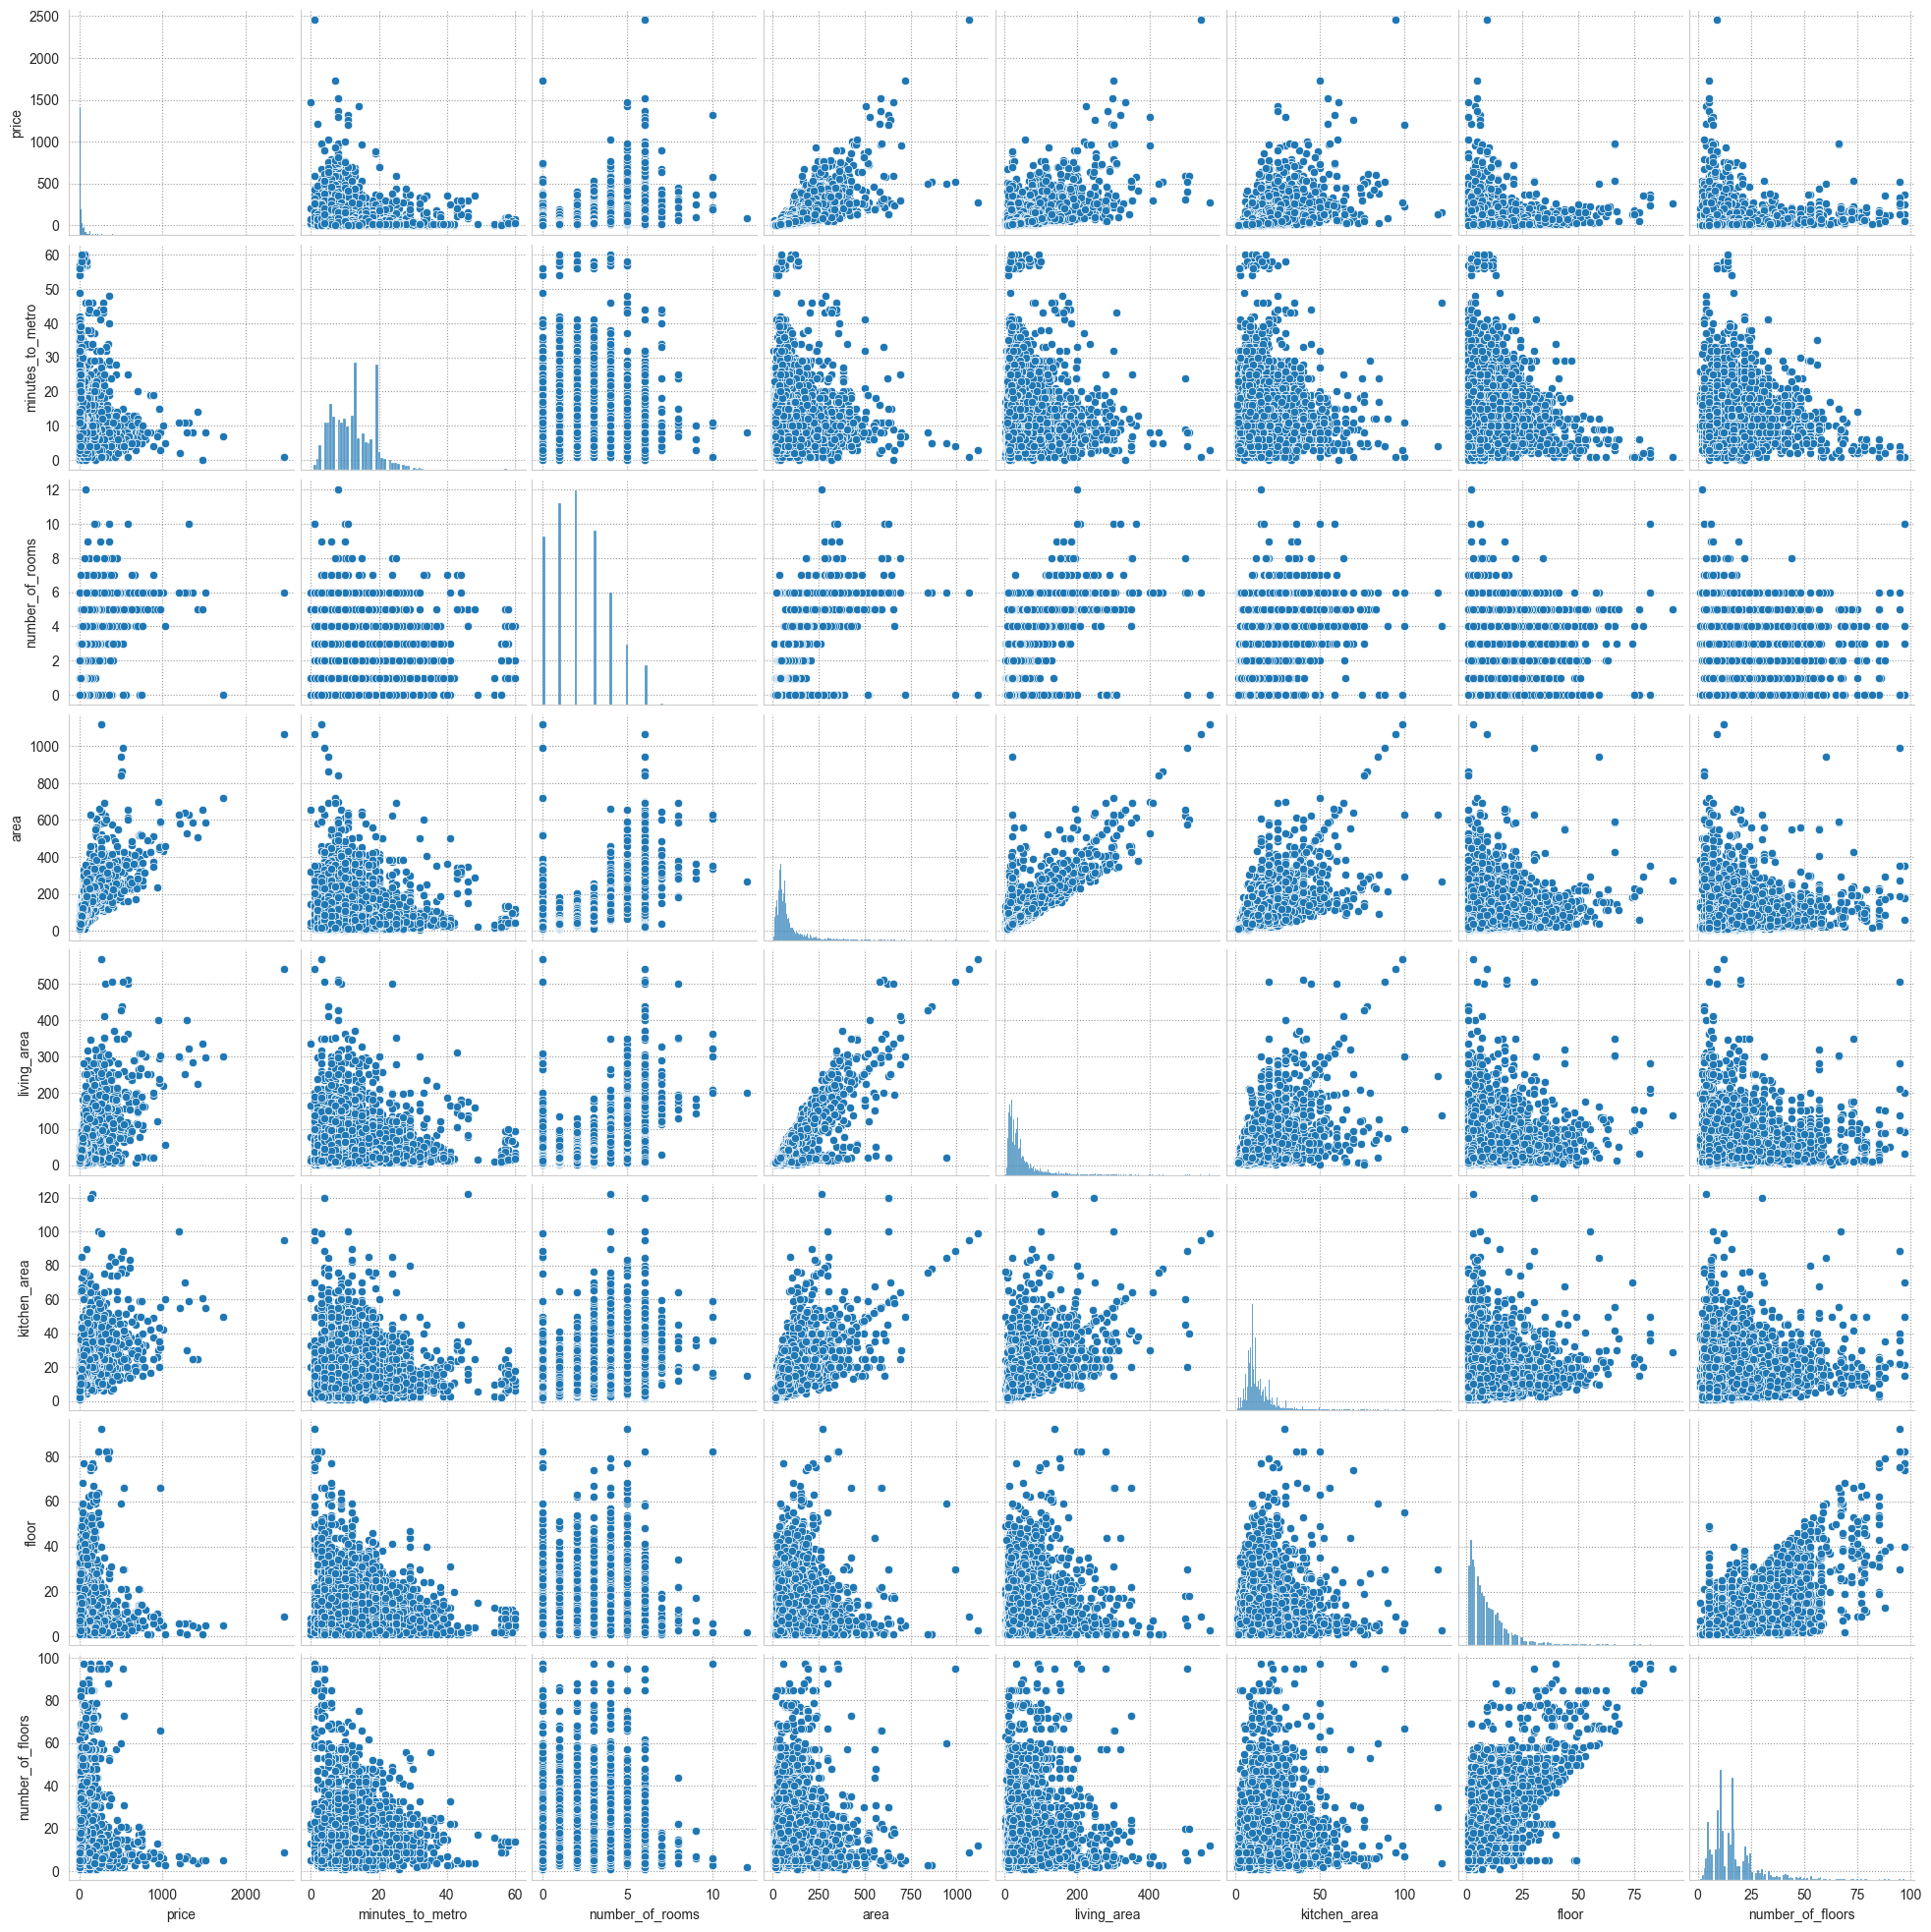

In [48]:
# Исследуем графически зависимость признаков на целевую переменную для обычной недвижимости
numeric_col = df.describe().columns
sns.pairplot(df[numeric_col])

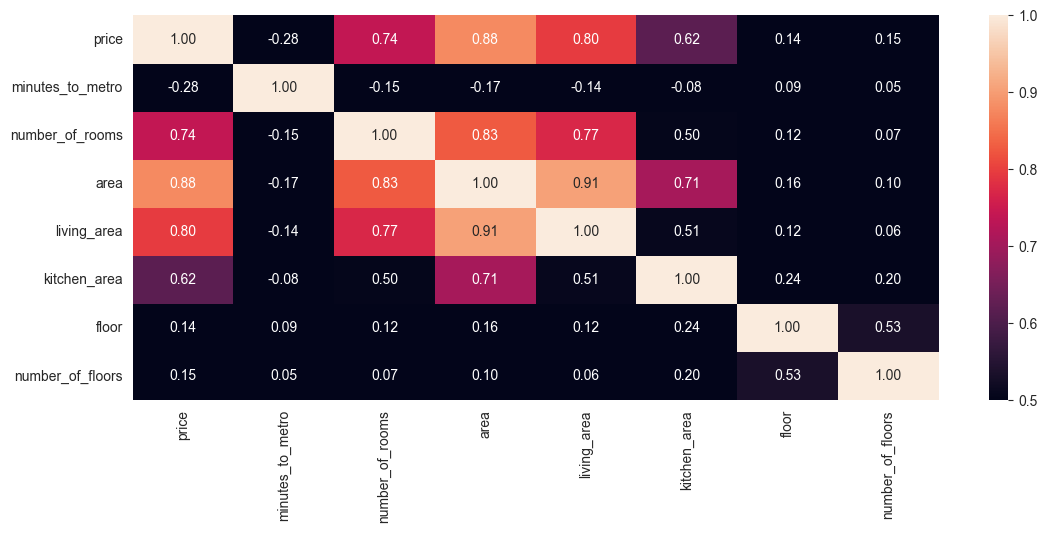

In [49]:
# Исследуем тепловую карту корреляции признаков на целевую переменную для обычной недвижимости
plt.figure(figsize=(13,5))
sns.heatmap(df.corr(method='spearman', numeric_only=True), annot=True, fmt='.2f', vmin=0.5)
plt.show()

In [50]:
# Проверим допущение о мультиколлинеарности
numeric_col = df.drop(columns='price').describe().columns
vif_data = pd.DataFrame()
vif_data.index = numeric_col

vif_data['VIF'] = [variance_inflation_factor(df[numeric_col].values, i) for i in range(len(numeric_col))]
vif_data

,VIF
minutes_to_metro,2.611041
number_of_rooms,4.917673
area,16.678503
living_area,11.109298
kitchen_area,7.187860
floor,3.787128
number_of_floors,4.807750


In [51]:
# Проверим допущение о мультиколлинеарности ещё раз
numeric_col = df.drop(columns=['price', 'living_area', 'kitchen_area', 'number_of_rooms']).describe().columns
vif_data = pd.DataFrame()
vif_data.index = numeric_col

vif_data['VIF'] = [variance_inflation_factor(df[numeric_col].values, i) for i in range(len(numeric_col))]
vif_data

,VIF
minutes_to_metro,2.230535
area,1.766682
floor,3.773531
number_of_floors,4.518966


Вывод: для обычной недвижимости четыре признака оказались менее 5, то есть с этими признаками можно работать

In [52]:
# Смотрим на колонки с категориальными переменными
df.describe(include='object')

,apartment_type,metro_station,renovation
count,16113,16113,16113
unique,2,542,4
top,Secondary,Депо,Cosmetic
freq,12500,1646,6462


Выводы:
1. у нас всего 2 типа аппартаментов в датасете
2. у нас всего 4 вида ремонта в датасете
3. станций метро в москве слишком много (вся россия работает на благоустройство москвы)

In [53]:
column_list = ['apartment_type']

for column in column_list:
    groups = []
    for unique_value in df[column].unique():
        groups.append(df[df[column] == unique_value]['price'])
    StatCriteria().mannwhitneyu(groups)

Mann-Whitney U test
U_statistic = 35653929.500
Распределения двух выборок не равны (p-value = 0.000).


In [54]:
column_list = ['metro_station', 'renovation']

for column in column_list:
    groups = []
    for unique_value in df[column].unique():
        groups.append(df[df[column] == unique_value]['price'])
    StatCriteria().kruskal(groups)

kruskal
statistic = 10685.468
Медианы всех групп не равны (p-value = 0.000).
kruskal
statistic = 5657.524
Медианы всех групп не равны (p-value = 0.000).


Вывод: на стоимость lowcost недвижимости влияют все категориальные переменные такие как:
1. apartment_type,
2. metro_station,
3. renovation

поэтому их все придётся учитывать при проведении регрессии.

In [55]:
df['apartment_type'] = Encoder().booleanOneColumnEncoder(df['apartment_type'], 'Secondary')
df['renovation'] = Encoder().labelEncoder(df['renovation'])
df['metro_station'], _ = Encoder().leaveOneOutEncoder(df['metro_station'], df['price'])

In [56]:
# проверяем датасет
df.head(5)

,price,apartment_type,metro_station,minutes_to_metro,number_of_rooms,area,living_area,kitchen_area,floor,number_of_floors,renovation
0,118.575675,1,181.340216,7,3,105.699997,84.8,15.900000,25,67,1
1,145.000000,1,360.831611,5,4,170.000000,125.0,18.000000,2,6,1
2,10.607020,0,9.765710,13,2,59.590000,27.1,16.700001,11,16,0
3,20.500000,1,47.415114,8,2,40.000000,30.0,5.000000,12,6,1
4,2.900000,1,12.931500,16,0,15.000000,9.7,7.900000,1,16,0


In [57]:
# подготавливаем данные
exclude_features = ['price', 'apartment_type', 'living_area', 'kitchen_area', 'number_of_rooms']
target = ['price']
X_train, X_test, y_train, y_test = DataPreparation().train_test_split(df, exclude_features, target)

# проводим нормализацию (логарифмирование)
X_train, X_test, y_train, y_test = Normalizer().log1p_norm(X_train, X_test, y_train, y_test)

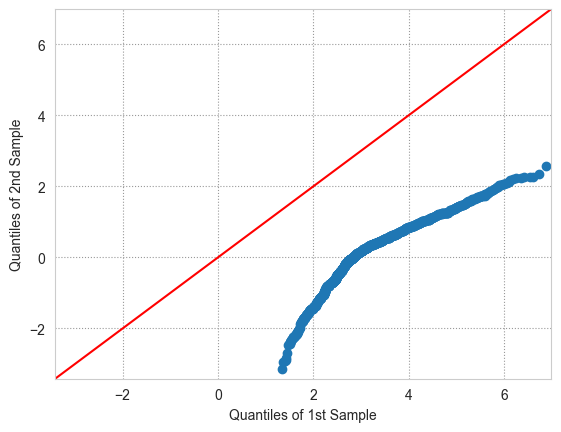

In [58]:
synt_data = np.random.normal(0, 1, 1000)
sm.qqplot_2samples(y_train, synt_data, line='45')
plt.show()

In [59]:
# Применяем готовую линейную регрессию из библиотеки statsmodels
y_test, y_pred, model = RegressionModel().OLS(X_train, X_test, y_train, y_test, prepend=False)
residuals = y_test - y_pred

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                 2.455e+04
Date:                Fri, 07 Feb 2025   Prob (F-statistic):               0.00
Time:                        23:07:33   Log-Likelihood:                -2376.8
No. Observations:               12084   AIC:                             4768.
Df Residuals:                   12077   BIC:                             4819.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
metro_station        0.4478      0.004  

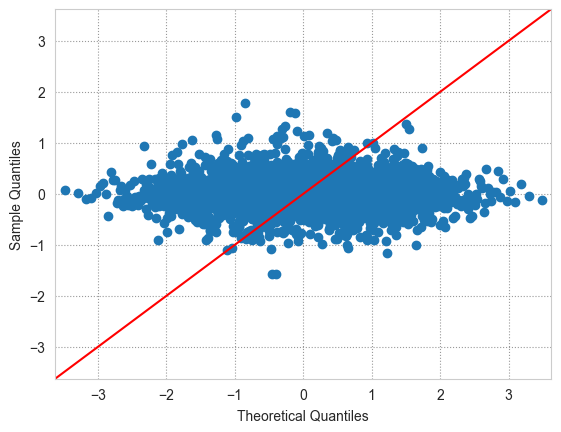

In [60]:
# Проверка на нормальность остатков
fig = sm.qqplot(residuals, line='45')
plt.show()

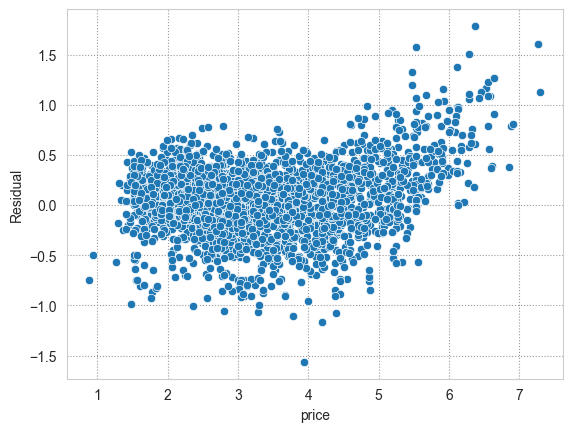

In [61]:
# Проверка на гомоскедастичность визуально
sns.scatterplot(x = y_test.squeeze(), y = residuals.squeeze())
plt.ylabel("Residual")
plt.show()

In [62]:
# Применяем Lasso регрессию
y_test, y_pred, model = RegressionModel().Lasso(X_train, X_test, y_train, y_test, alpha=0.01)

R²: 0.921
MAE: 0.22
MAPE: 7%
RMSE: 0
MSE: 0
__________
Коэффициенты Lasso-регрессии:
metro_station: 0.45
minutes_to_metro: -0.02
area: 0.90
floor: 0.00
number_of_floors: 0.00
renovation: 0.08


Вывод: признаки minutes_to_metro, floor, number_of_floors не сильно влияют на таргет

In [63]:
# подготавливаем данные
exclude_features = ['price', 'living_area', 'kitchen_area', 'number_of_rooms', 'minutes_to_metro', 'floor', 'number_of_floors']
target = ['price']
X_train, X_test, y_train, y_test = DataPreparation().train_test_split(df, exclude_features, target)

# проводим нормализацию (логарифмирование)
X_train, X_test, y_train, y_test = Normalizer().log1p_norm(X_train, X_test, y_train, y_test)
X_train, X_test, _ = Normalizer().MinMaxScaler(X_train, X_test)
X_train, X_test, y_train, y_test = Normalizer().reset_index(X_train, X_test, y_train, y_test)

In [64]:
# Применяем готовую линейную регрессию из библиотеки statsmodels
y_test, y_pred, model = RegressionModel().OLS(X_train, X_test, y_train, y_test, prepend=False)
residuals = y_test - y_pred

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 3.948e+04
Date:                Fri, 07 Feb 2025   Prob (F-statistic):               0.00
Time:                        23:07:33   Log-Likelihood:                -1946.9
No. Observations:               12084   AIC:                             3904.
Df Residuals:                   12079   BIC:                             3941.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
apartment_type     0.2561      0.008     32.

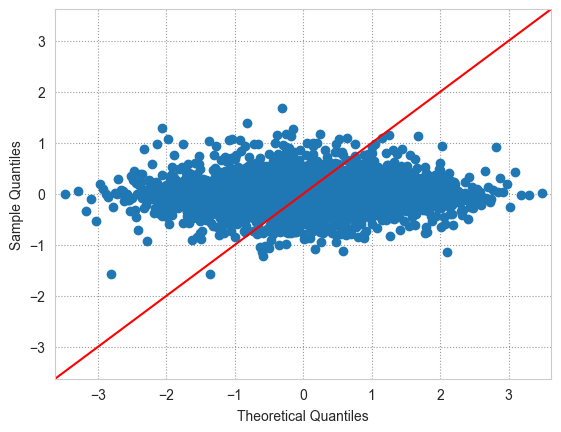

In [65]:
# Проверка на нормальность остатков
fig = sm.qqplot(residuals, line='45')
plt.show()

In [66]:
# Применяем Ridge регрессию
y_test, y_pred, model = RegressionModel().Ridge(X_train, X_test, y_train, y_test, alpha=0.01)
residuals = y_test - y_pred

R²: 0.929
MAE: 0.20
MAPE: 7%
RMSE: 0
MSE: 0
__________
Коэффициенты Ridge-регрессии:
apartment_type: 0.26
metro_station: 1.91
area: 4.85
renovation: 0.04


## проводим полиномиальную регрессию лог-нормальных данных

In [67]:
# Подготавливаем данные
exclude_features = ['price', 'living_area', 'kitchen_area', 'number_of_rooms', 'minutes_to_metro', 'floor', 'number_of_floors']
target = ['price']
X_train, X_test, y_train, y_test = DataPreparation().train_test_split(df, exclude_features, target)

# Нормализуем данные (логарифмирование)
X_train, X_test, y_train, y_test = Normalizer().log1p_norm(X_train, X_test, y_train, y_test)
X_train, X_test, _ = Normalizer().MinMaxScaler(X_train, X_test)
X_train, X_test, y_train, y_test = Normalizer().reset_index(X_train, X_test, y_train, y_test)

In [68]:
# Трансформируем Х в полиномиальные признаки
X_train, X_test, y_train, y_test = RegressionModel().PolynomialFeatures(X_train, X_test, y_train, y_test, include_bias=False)

In [69]:
y_test, y_pred, _ = RegressionModel().OLS(X_train, X_test, y_train, y_test, prepend=False)
residuals = y_test - y_pred

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                 1.463e+04
Date:                Fri, 07 Feb 2025   Prob (F-statistic):               0.00
Time:                        23:07:33   Log-Likelihood:                -891.83
No. Observations:               12084   AIC:                             1812.
Df Residuals:                   12070   BIC:                             1915.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
apartment_type  

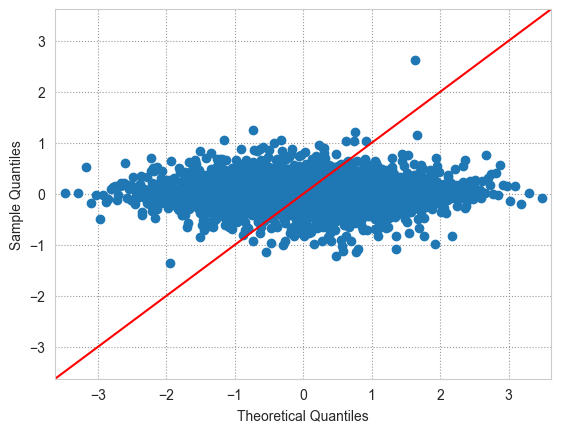

In [70]:
# Проверка на нормальность остатков
fig = sm.qqplot(residuals, line='45')
plt.show()

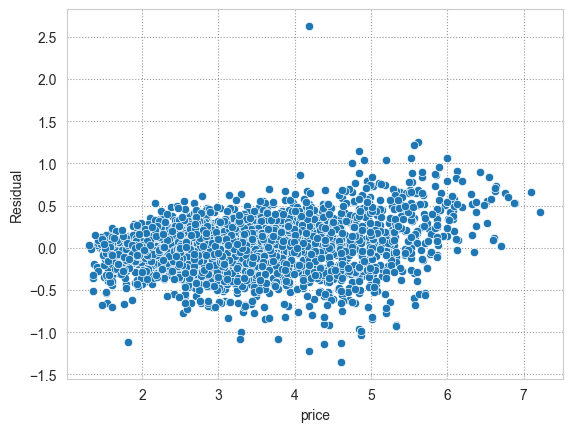

In [71]:
# Проверка на гомоскедастичность визуально
sns.scatterplot(x = y_test.squeeze(), y = residuals.squeeze())
plt.ylabel("Residual")
plt.show()

## проводим обобщённую линейную регрессию на базе экспоненциального распределения

In [72]:
# подготавливаем данные
exclude_features = ['price', 'apartment_type', 'living_area', 'kitchen_area', 'number_of_rooms']
target = ['price']
X_train, X_test, y_train, y_test = DataPreparation().train_test_split(df, exclude_features, target)

# Нормализуем данные (логарифмирование)
X_train, X_test, y_train, y_test = Normalizer().log1p_norm(X_train, X_test, y_train, y_test)

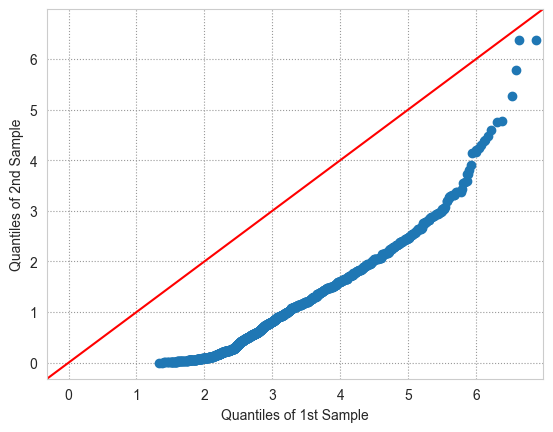

In [73]:
theoretical_distribution = np.random.exponential(1, 1000)
sm.qqplot_2samples(y_train, theoretical_distribution, line='45')
plt.show()

In [74]:
y_test, y_pred, _ = RegressionModel().GLM(X_train, X_test, y_train, y_test, prepend=False)
residuals = y_test - y_pred

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  price   No. Observations:                12084
Model:                            GLM   Df Residuals:                    12077
Model Family:                   Gamma   Df Model:                            6
Link Function:                    Log   Scale:                       0.0074710
Method:                          IRLS   Log-Likelihood:                -756.94
Date:                Fri, 07 Feb 2025   Deviance:                       90.034
Time:                        23:07:34   Pearson chi2:                     90.2
No. Iterations:                    10   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
metro_station        0.1181      0.001  